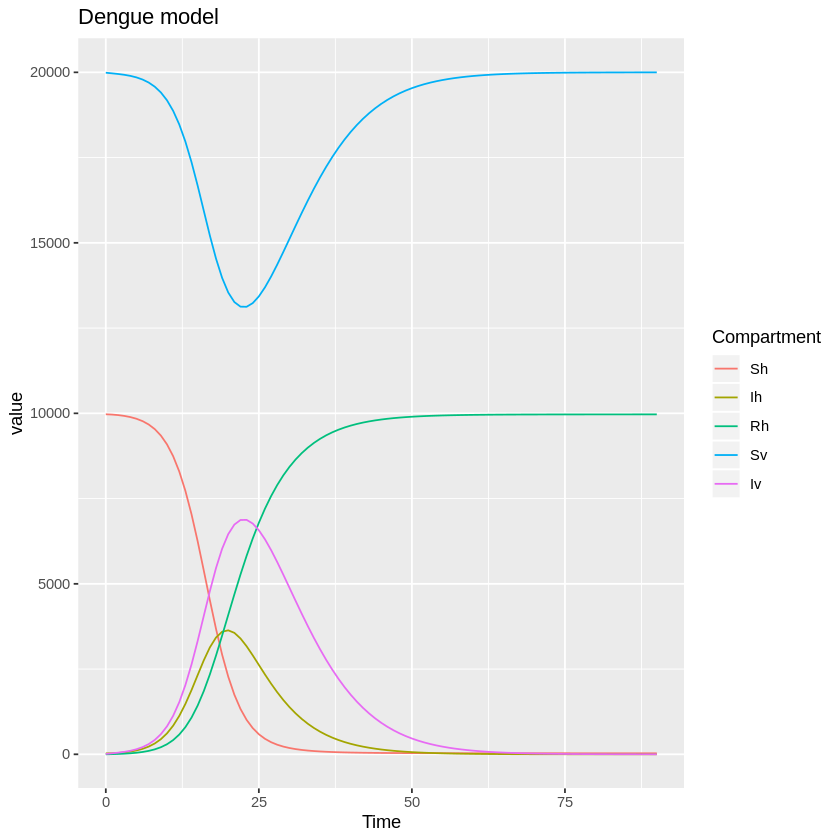

In [4]:
require(deSolve)
require(reshape2)
require(ggplot2)

# INPUT
Nh <- 10000   # total number of hosts
Nv <- 20000   # total number of vectors

initial_state_values <- c(Sh = Nh-0.0028*Nh, 
                          Ih = 0.0028*Nh, 
                          Rh = 0, 
                          Sv = Nv-0.00057*Nv,
                          Iv = 0.00057*Nv)

parameters <- c(a = 1,       # bit rate 
                b_v = 0.4,   # probability of infection from host to vector
                b_h = 0.4,   # probability of infection from vector to a susceptible host
                u_v = 0.25,  # mortality rate
                r = 0.167)   #recovery rate

times<-seq(0,90,by=1)

mos_model<-function(time,state,parameters){
    with(as.list(c(state,parameters)),
    {
        N_H<-Sh+Ih+Rh
        N_V<-Sv+Iv
        
        #Host dynamics
        dSh<--a*b_h*Iv*(Sh/N_H)
        dIh<-a*b_h*Iv*(Sh/N_H)-r*Ih
        dRh<-r*Ih
        
        #Vector dynamics
        dSv<-u_v*N_V-u_v*Sv-a*b_v*(Ih/N_H)*Sv
        dIv<-a*b_v*(Ih/N_H)*Sv-u_v*Iv
        
        
        return(list(c(dSh,dIh,dRh,dSv,dIv)))
    })
}

output<-as.data.frame(ode(y=initial_state_values,
                         time=times,
                         func=mos_model,
                         parms=parameters))
output_long<-melt(as.data.frame(output),id="time")
ggplot(data=output_long,aes(x=time,y=value,colour=variable,group=variable))+geom_line()+
xlab("Time")+  labs(colour = "Compartment", title = "Dengue model") 


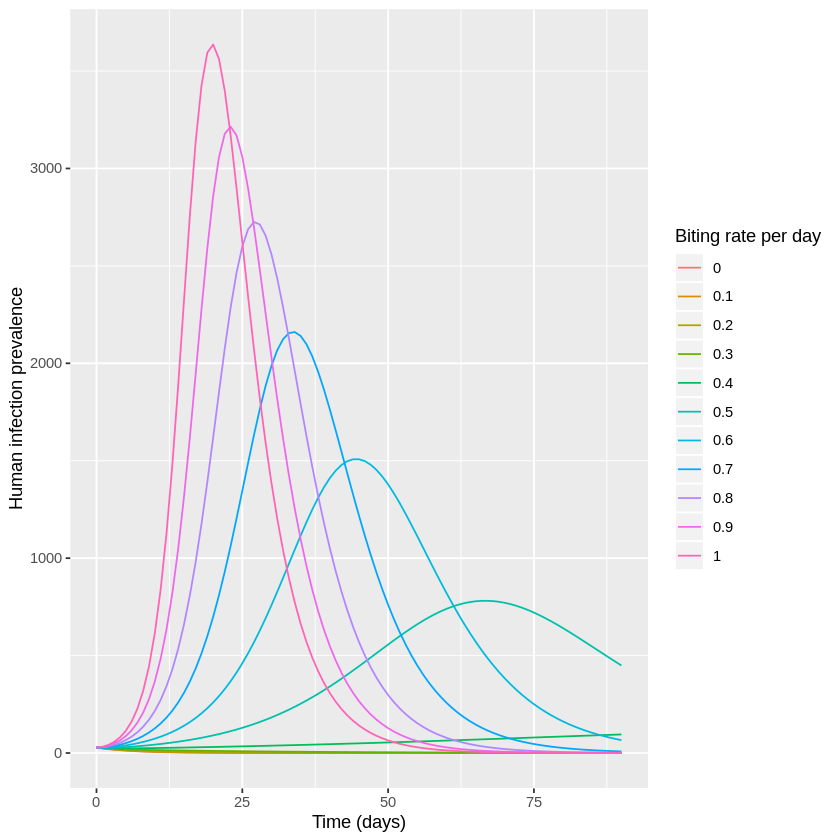

In [9]:
a_values <- seq(0,1,by=0.1)                        # a vector of values for the biting rate, ranging from 0 to 1 per day
out_list <- vector(length(a_values), mode = "list")# create an object (list) to store the output for each value of a

for (i in seq_along(a_values)) {      # start for loop: for each value in the a_values vector...

# ... simulate the model and store the output in the out_list object:
out_list[[i]] <- as.data.frame(ode(y = initial_state_values, 
                                   times = times, 
                                   func = mos_model,
                                   parms = c(parameters[c("b_v", "b_h", "u_v", "r")],          # fill in remaining parameter values
                                             a = a_values[i])))
}                                      # close the loop
                                   
names(out_list) <- a_values            # rename list elements according to the corresponding biting rate value
                                   
# Extract the infected host column from the list and creating a dataframe by time
out_inf <- cbind(time = out_list[[1]]$time, 
                 sapply(out_list, 
                        "[[", 
                        "Ih"))    # fill in the name of your column for infected hosts                          

# Turn into long format                                
out_inf_long <- melt(as.data.frame(out_inf), id = "time") 

# Plot the infection prevalence for each biting rate value                                   
ggplot(data = out_inf_long,                                               
       aes(x = time, y = value, colour = variable, group = variable)) +  
  geom_line() +
  xlab("Time (days)") +                                                   
  ylab("Human infection prevalence") +                                     
  labs(colour = "Biting rate per day") 